# Install Libraries

In [49]:
!pip install tensorflow pandas numpy sklearn
!pip install pandas scikit-learn
!pip install lime shap

  Using cached sklearn-0.0.post11.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Import Libraries

In [50]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.metrics import AUC, Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.tseries.offsets import DateOffset
from sklearn import metrics

# Read Preprocessed Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/JP/JP_preprocessed_df.csv'

# Preparing for Tree Based Model

## Pre-processing Australian Dataset for tree based models

In [52]:
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def process_au_dataframe(file_path):
    AU_df = pd.read_csv(file_path)
    AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
    AU_df = AU_df.reset_index(drop=True)

    # Convert 'COLLECTED' to float for calculation purposes
    AU_df['COLLECTED'] = AU_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID'
    grouped = AU_df.groupby('ID')

    # Compute slopes for each group and directly assign them to the DataFrame
    AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

    # Calculate mean and std for eGFR
    AU_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    AU_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    AU_df.fillna(0, inplace=True)

    return AU_df

## Pre-processing Japanese Dataset for tree based models

In [53]:
# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def process_dataframe(file_path):
    JP_df = pd.read_csv(file_path)
    JP_df = JP_df.reset_index(drop=True)

    # Apply the function to the 'Time' column to create a new 'Months' column
    JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

    # Assume a starting date for all IDs
    start_date = pd.Timestamp('2020-01-01')

    # Create a 'COLLECTED' column based on the 'Months' column
    JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

    # Convert 'COLLECTED' to float for calculation purposes
    JP_df['COLLECTED'] = JP_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID' and calculate slopes, mean, and std for eGFR
    grouped = JP_df.groupby('ID')
    JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']
    JP_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    JP_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    JP_df.fillna(0, inplace=True)

    return JP_df

In [54]:
AU_df = process_au_dataframe(file_path_AU_preprocessed)
AU_df

<ipython-input-52-4d83e8953e0a>:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,COLLECTED,ID,SEX,AGE,eGFR,Kidney_Failure,eGFR_slope,eGFR_mean,eGFR_std
0,737062.510417,2,1,45,23,1,-0.045462,18.055556,2.099642
1,737098.010417,2,1,46,19,1,-0.045462,18.055556,2.099642
2,737100.036806,2,1,46,17,1,-0.045462,18.055556,2.099642
3,737115.687500,2,1,46,15,1,-0.045462,18.055556,2.099642
4,737122.458333,2,1,46,15,1,-0.045462,18.055556,2.099642
...,...,...,...,...,...,...,...,...,...
154511,738609.187500,149302,1,84,55,0,-2.396167,52.666667,2.516611
154512,738610.229167,149302,1,84,50,0,-2.396167,52.666667,2.516611
154513,738608.819444,149311,1,72,55,0,-3.435050,50.666667,3.785939
154514,738609.329167,149311,1,72,48,0,-3.435050,50.666667,3.785939


In [55]:
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df

<ipython-input-53-d26d83f09be9>:40: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


# Analysis

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

# Assuming AU_df and JP_df are your Australian and Japanese datasets respectively

# Descriptive statistics for continuous variables
au_descriptive = AU_df[['AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']].describe()
jp_descriptive = JP_df[['AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']].describe()

# Descriptive statistics for categorical variables
au_categorical = AU_df[['SEX', 'Kidney_Failure']].astype('category').describe()
jp_categorical = JP_df[['SEX', 'Kidney_Failure']].astype('category').describe()

print(au_descriptive)
print(jp_descriptive)
print(au_categorical)
print(jp_categorical)

                 AGE           eGFR     eGFR_slope      eGFR_mean  \
count  154516.000000  154516.000000  154516.000000  154516.000000   
mean       77.538371      46.642956       0.165648      46.642956   
std        12.017280      18.364515       1.869981      15.705679   
min        18.000000      15.000000     -51.135708      15.000000   
25%        72.000000      33.000000      -0.014577      34.750000   
50%        80.000000      44.000000      -0.001177      44.896552   
75%        86.000000      58.000000       0.018645      56.842105   
max       106.000000      91.000000      83.378656      90.326531   

            eGFR_std  
count  154516.000000  
mean        8.778338  
std         4.381331  
min         0.000000  
25%         5.718781  
50%         8.038240  
75%        11.113736  
max        36.950417  
               AGE         eGFR   eGFR_slope    eGFR_mean     eGFR_std
count  3388.000000  3388.000000  3388.000000  3388.000000  3388.000000
mean     71.549587    36.6196

In [30]:
# import pandas as pd
# import numpy as np
# from scipy.stats import ttest_ind, chi2_contingency

# # Assuming AU_df and JP_df are your Australian and Japanese datasets respectively

# # T-test for continuous variables to compare means
# # Using Welch's T-test (which does not assume equal population variance)
# t_stat, p_value = ttest_ind(AU_df['eGFR'], JP_df['eGFR'], equal_var=False)
# print(f"T-test p-value for eGFR: {p_value}")

# # Convert SEX to a categorical type if not already done
# AU_df['SEX'] = AU_df['SEX'].astype('category')
# JP_df['SEX'] = JP_df['SEX'].astype('category')

# # Get the contingency table for SEX categories
# contingency_table = pd.crosstab(AU_df['SEX'], JP_df['SEX'])

# # Perform the Chi-square test
# chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)
# print(f"Chi-square test p-value for SEX: {p_value}")

# # Function to calculate Standardized Mean Difference (SMD)
# def calculate_smd(mean1, std1, n1, mean2, std2, n2):
#     pooled_sd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
#     return (mean1 - mean2) / pooled_sd

# # Calculating SMD for each variable
# features = ['AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']
# smd_values = {}

# for feature in features:
#     mean1 = AU_df[feature].mean()
#     std1 = AU_df[feature].std()
#     n1 = AU_df[feature].count()

#     mean2 = JP_df[feature].mean()
#     std2 = JP_df[feature].std()
#     n2 = JP_df[feature].count()

#     smd_values[feature] = calculate_smd(mean1, std1, n1, mean2, std2, n2)

# # Display the SMD values
# for feature, value in smd_values.items():
#     print(f"SMD for {feature}: {value}")

T-test p-value for eGFR: 5.361239435432905e-277
Chi-square test p-value for SEX: 0.0015016225979146832
SMD for AGE: 0.49882454261555953
SMD for eGFR: 0.5478868610476006
SMD for eGFR_slope: 0.09208005320056517
SMD for eGFR_mean: 0.6399406239495692
SMD for eGFR_std: 0.8145420714228679


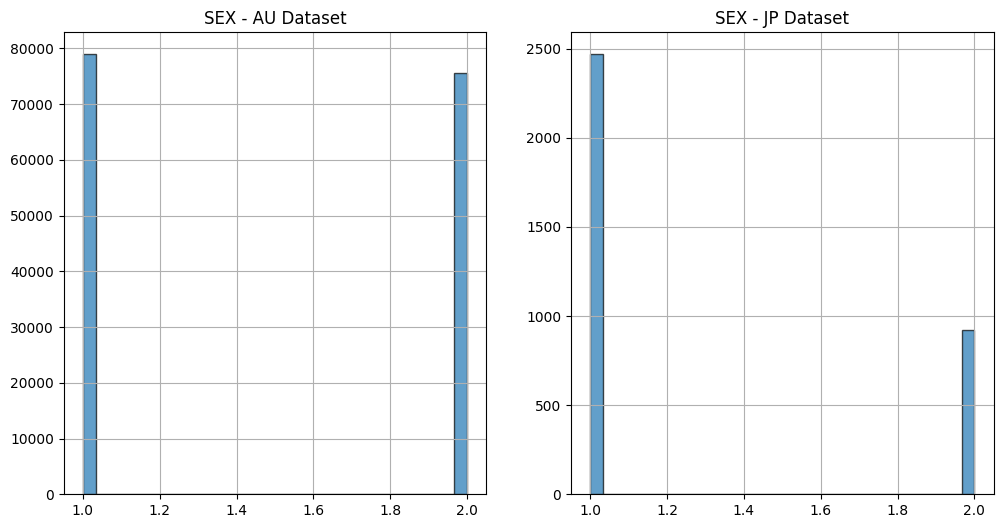

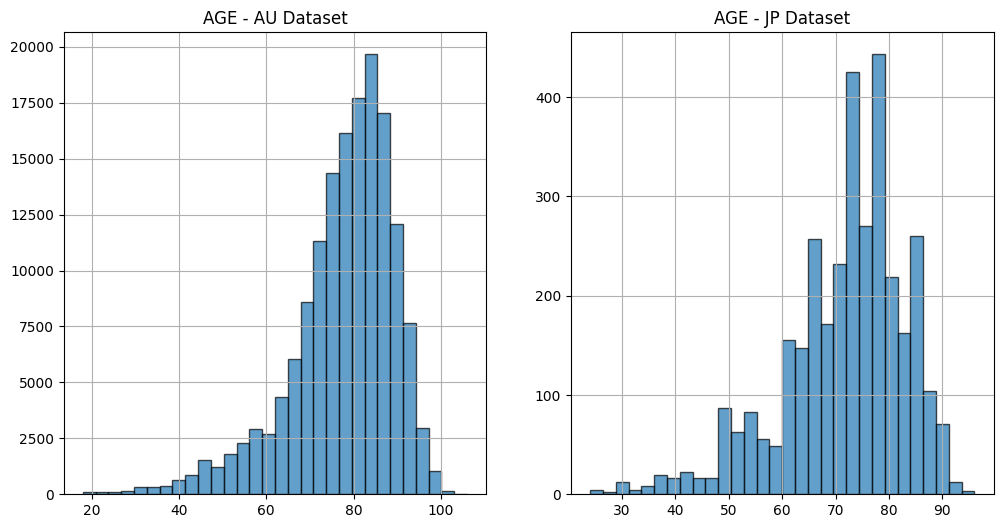

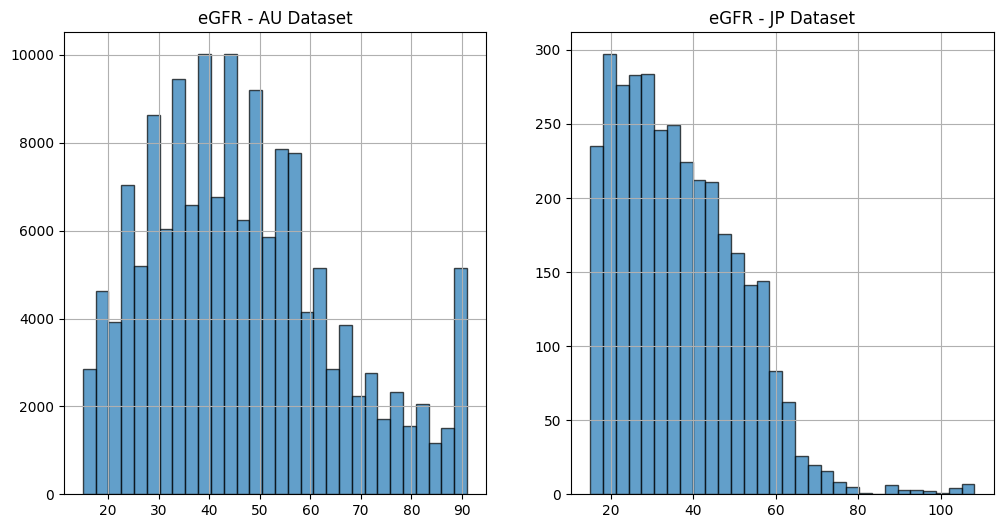

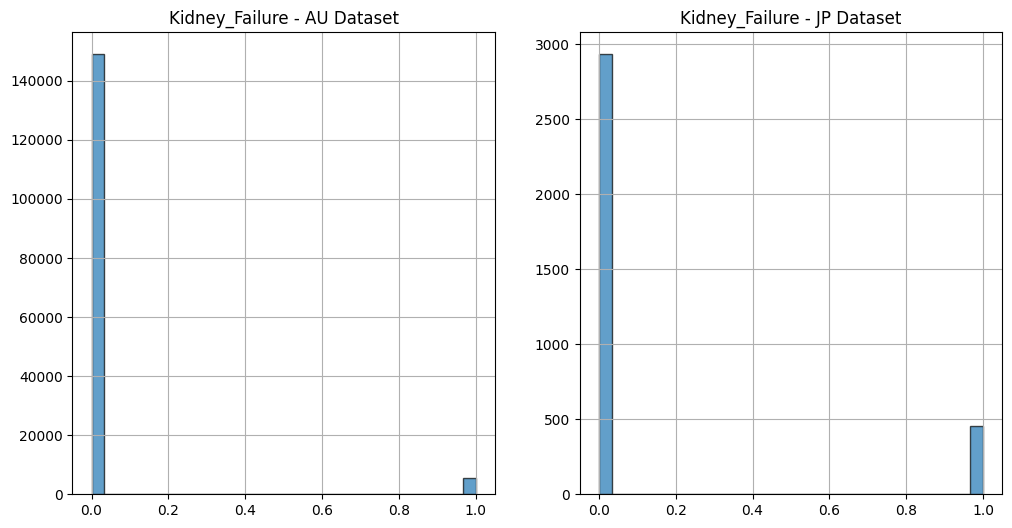

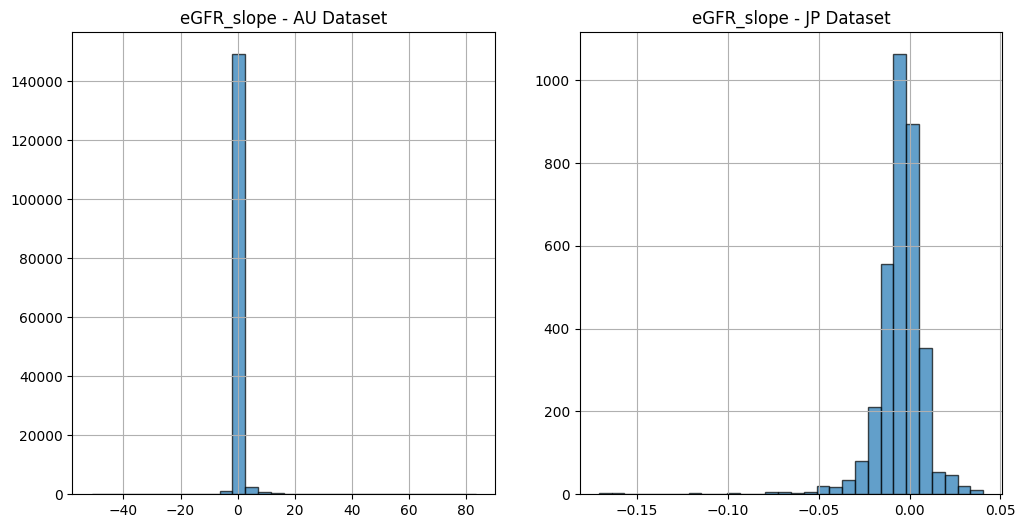

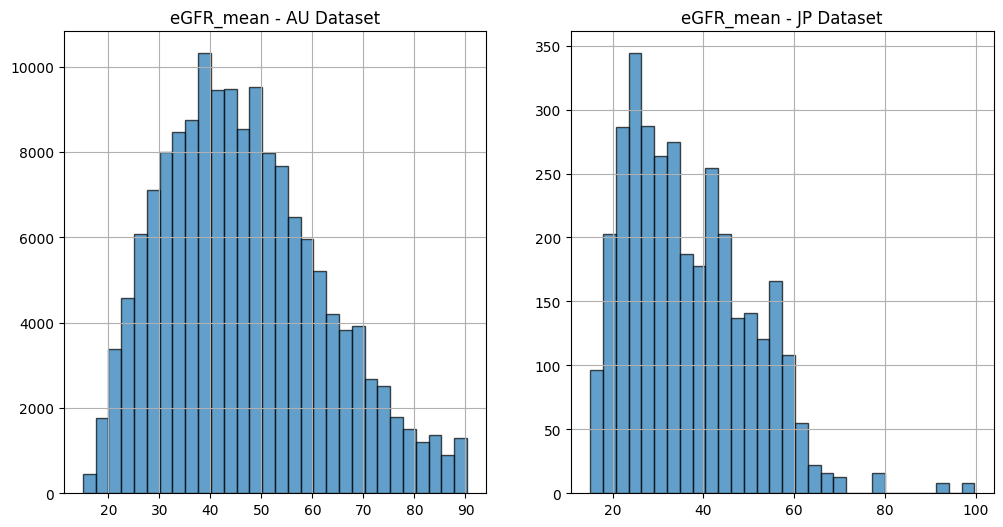

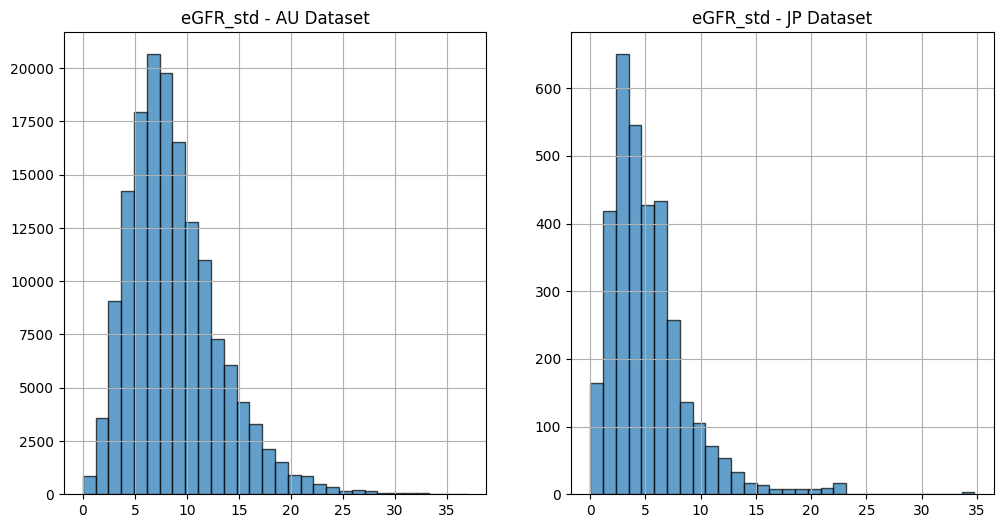

Summary statistics for AU Dataset:
                 SEX            AGE           eGFR  Kidney_Failure  \
count  154516.000000  154516.000000  154516.000000   154516.000000   
mean        1.489095      77.538371      46.642956        0.035873   
std         0.499883      12.017280      18.364515        0.185975   
min         1.000000      18.000000      15.000000        0.000000   
25%         1.000000      72.000000      33.000000        0.000000   
50%         1.000000      80.000000      44.000000        0.000000   
75%         2.000000      86.000000      58.000000        0.000000   
max         2.000000     106.000000      91.000000        1.000000   

          eGFR_slope      eGFR_mean       eGFR_std  
count  154516.000000  154516.000000  154516.000000  
mean        0.165648      46.642956       8.778338  
std         1.869981      15.705679       4.381331  
min       -51.135708      15.000000       0.000000  
25%        -0.014577      34.750000       5.718781  
50%        -0.00

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming AU_df and JP_df are already loaded DataFrames
# Select the features you are interested in
features = ['SEX', 'AGE', 'eGFR', 'Kidney_Failure', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']

# Iterate over each feature and plot the distribution for both datasets
for feature in features:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    AU_df[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - AU Dataset')

    plt.subplot(1, 2, 2)
    JP_df[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - JP Dataset')

    plt.show()

# Display summary statistics for both datasets
print("Summary statistics for AU Dataset:")
print(AU_df[features].describe())

print("\nSummary statistics for JP Dataset:")
print(JP_df[features].describe())

Chi-squared: 627.3565208278894, p-value: 1.8782601248822106e-138, Cramer's V: 0.06303193540672015


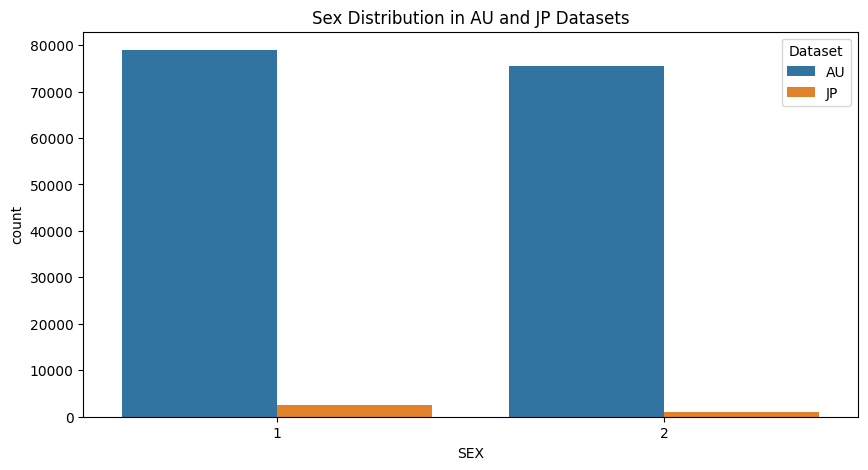

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic: 38.90859240076391, p-value: 1.5065311682743323e-232, Effect size: 347169000.5
AU Age 95% confidence interval: (77.47845201759716, 77.5982908439835)
JP Age 95% confidence interval: (71.16337706512716, 71.93579648859183)


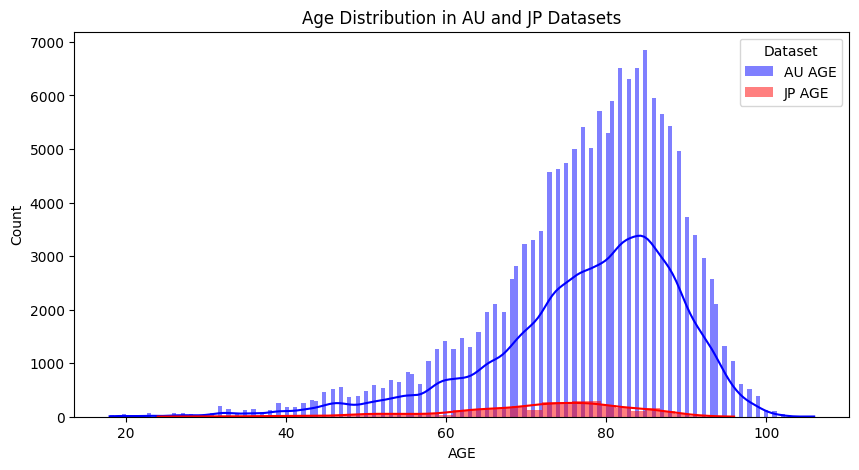

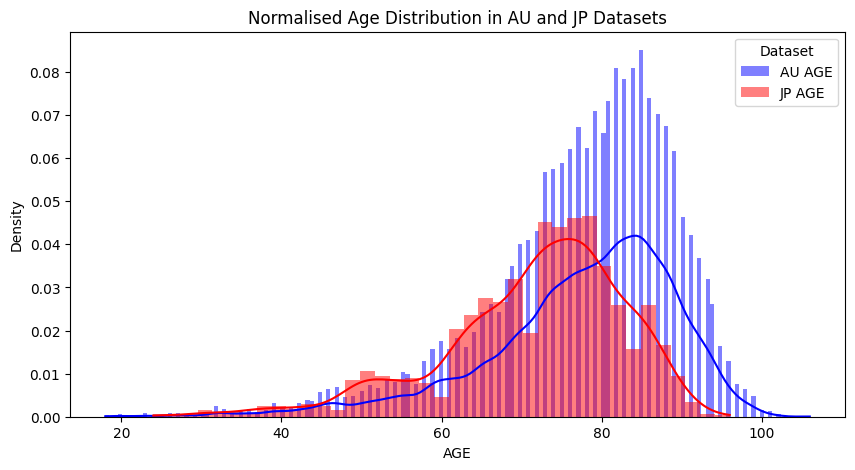

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable: eGFR, Test used: Mann-Whitney U, Statistic: 38.90859240076391, p-value: 2.007101571134445e-225, Effect size: -0.32135287327335704


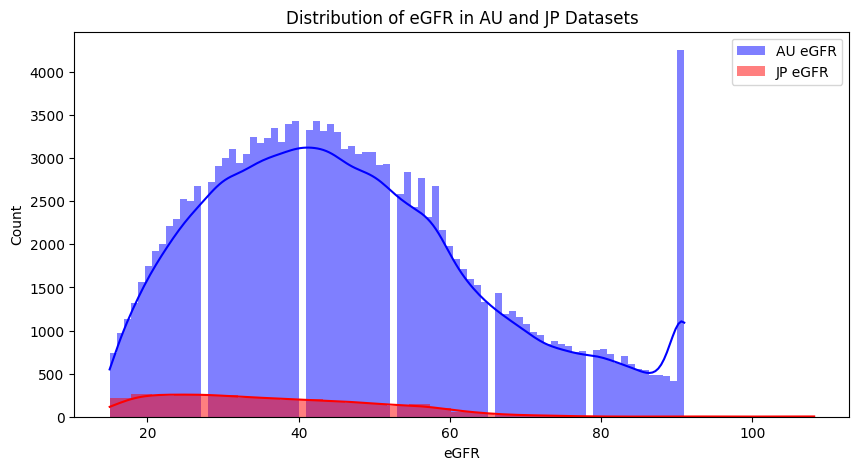

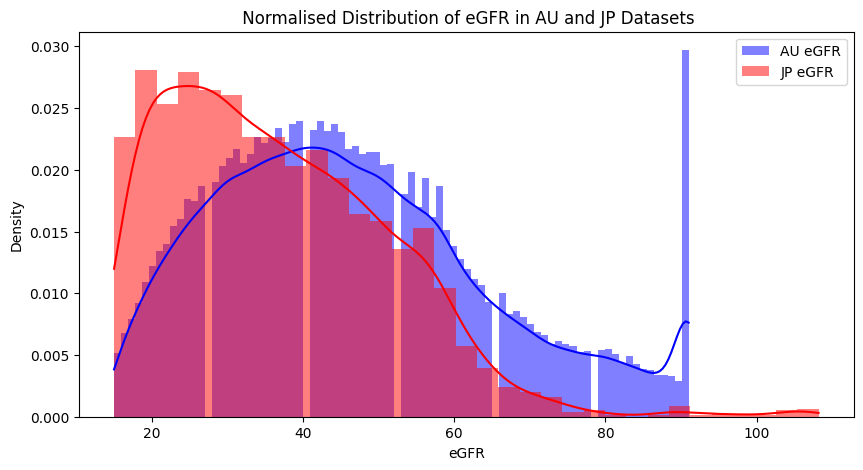

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable: eGFR_mean, Test used: Mann-Whitney U, Statistic: 38.90859240076391, p-value: 3.538707014723544e-301, Effect size: -0.371946052789343


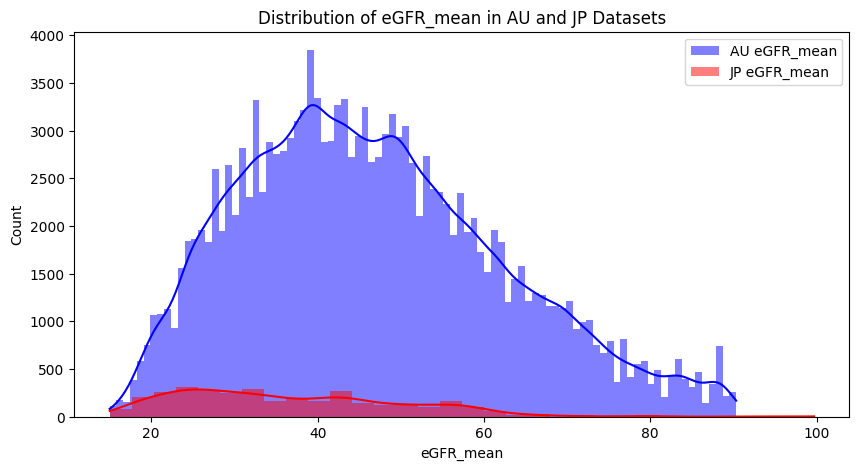

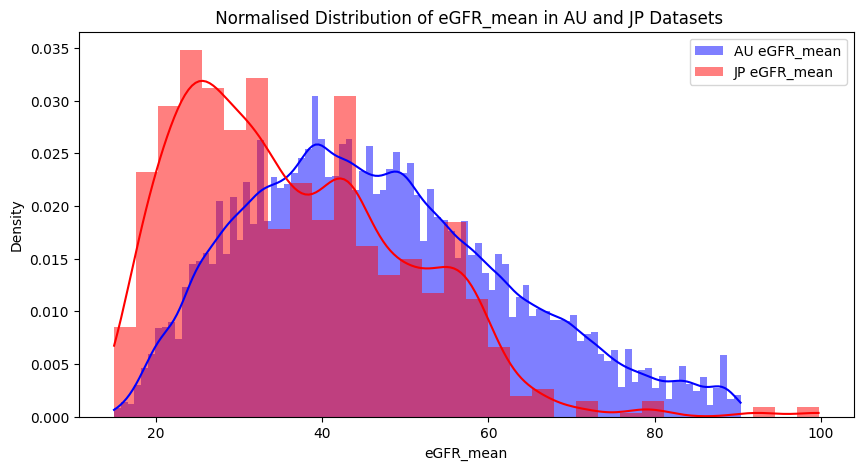

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable: eGFR_slope, Test used: Mann-Whitney U, Statistic: 38.90859240076391, p-value: 1.7502050012959092e-32, Effect size: -0.11899559168847551


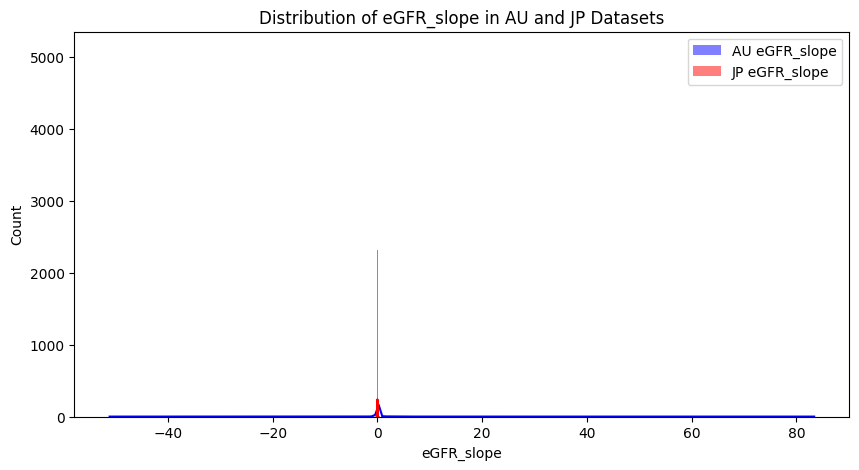

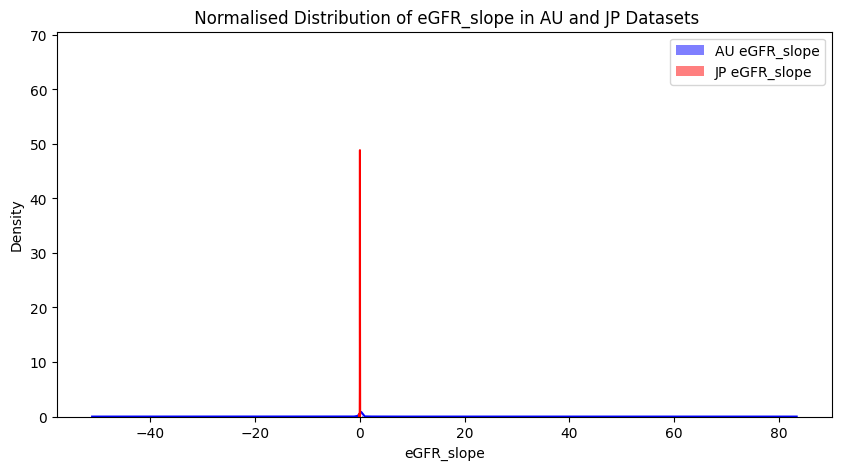

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable: eGFR_std, Test used: Mann-Whitney U, Statistic: 38.90859240076391, p-value: 0.0, Effect size: -0.5288957191780141


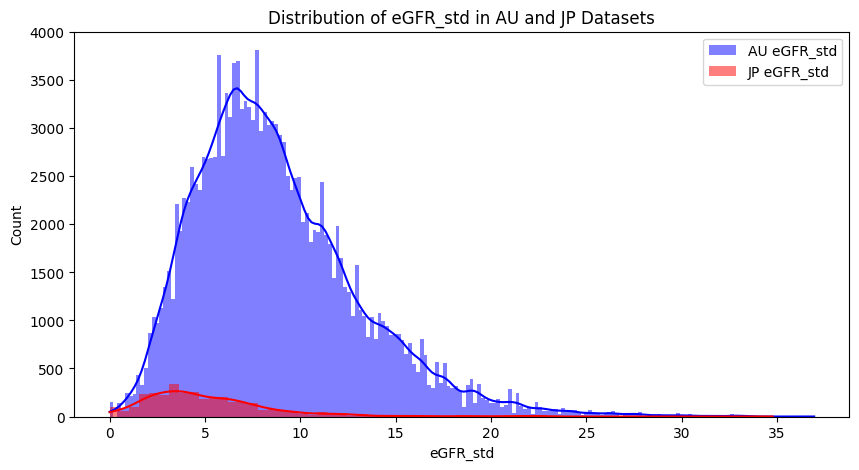

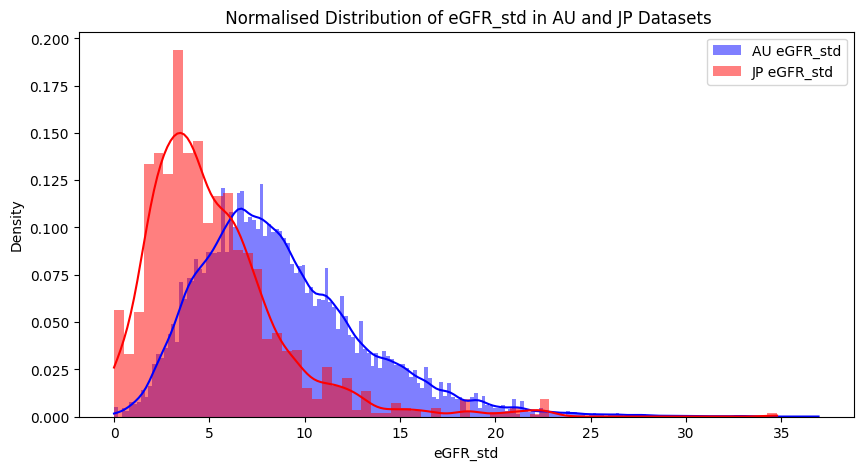

Chi-squared: 881.3245240590148, p-value: 1.1263982493119976e-193, Cramer's V: 0.07470873137655232


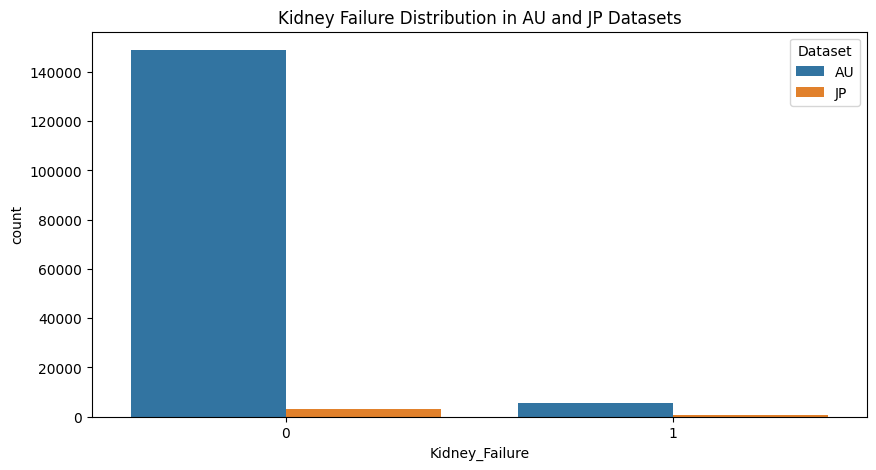

In [58]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a combined DataFrame with an additional column indicating the dataset
combined_df = pd.concat([
    AU_df.assign(Dataset='AU'),
    JP_df.assign(Dataset='JP')
])

# Create a contingency table for gender across AU and JP datasets
gender_table = pd.crosstab(combined_df['SEX'], combined_df['Dataset'])

# Perform Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(gender_table)

# Calculate Cramer's V for effect size
n = np.sum(gender_table.values)
cramers_v = np.sqrt(chi2 / (n*(min(gender_table.shape)-1)))

print(f"Chi-squared: {chi2}, p-value: {p}, Cramer's V: {cramers_v}")

# Compare distributions using bar plot for categorical data
plt.figure(figsize=(10, 5))
sns.countplot(x='SEX', hue='Dataset', data=pd.concat([AU_df.assign(Dataset='AU'), JP_df.assign(Dataset='JP')]))
plt.title('Sex Distribution in AU and JP Datasets')
plt.legend(title='Dataset')
plt.show()

# ---------------------------------------------------------------------------------------------------------------------

# Check for normality and perform the appropriate test for AGE
au_age_normal = stats.shapiro(AU_df['AGE']).pvalue > 0.05
jp_age_normal = stats.shapiro(JP_df['AGE']).pvalue > 0.05
if au_age_normal and jp_age_normal:
    # Use t-test for normally distributed data
    t_stat, p_value = stats.ttest_ind(AU_df['AGE'], JP_df['AGE'])
    effect_size = np.mean(AU_df['AGE']) - np.mean(JP_df['AGE'])
else:
    # Use Mann-Whitney U test for non-normally distributed data
    u_stat, p_value = stats.mannwhitneyu(AU_df['AGE'], JP_df['AGE'])
    effect_size = u_stat

# Calculate confidence intervals for age means
au_conf_int = stats.norm.interval(0.95, loc=np.mean(AU_df['AGE']), scale=stats.sem(AU_df['AGE']))
jp_conf_int = stats.norm.interval(0.95, loc=np.mean(JP_df['AGE']), scale=stats.sem(JP_df['AGE']))

print(f"Statistic: {t_stat or u_stat}, p-value: {p_value}, Effect size: {effect_size}")
print(f"AU Age 95% confidence interval: {au_conf_int}")
print(f"JP Age 95% confidence interval: {jp_conf_int}")

# Compare distributions using histogram and KDE plot for continuous data
plt.figure(figsize=(10, 5))
sns.histplot(AU_df['AGE'], color='blue', label='AU AGE', kde=True, linewidth=0)
sns.histplot(JP_df['AGE'], color='red', label='JP AGE', kde=True, linewidth=0)
plt.title('Age Distribution in AU and JP Datasets')
plt.legend(title='Dataset')
plt.show()

# Compare distributions using histogram and KDE plot for continuous data
plt.figure(figsize=(10, 5))
sns.histplot(AU_df['AGE'], color='blue', label='AU AGE', kde=True, stat="density", linewidth=0)
sns.histplot(JP_df['AGE'], color='red', label='JP AGE', kde=True, stat="density", linewidth=0)
plt.title('Normalised Age Distribution in AU and JP Datasets')
plt.legend(title='Dataset')
plt.show()

# ---------------------------------------------------------------------------------------------------------------------

variables_to_test = ['eGFR', 'eGFR_mean', 'eGFR_slope', 'eGFR_std']

for var in variables_to_test:
    # Check for normality in both datasets
    au_normal = stats.shapiro(AU_df[var]).pvalue > 0.05
    jp_normal = stats.shapiro(JP_df[var]).pvalue > 0.05

    # If both are normally distributed, use t-test
    if au_normal and jp_normal:
        t_stat, p_value = stats.ttest_ind(AU_df[var], JP_df[var], equal_var=False)
        effect_size = (np.mean(AU_df[var]) - np.mean(JP_df[var])) / np.sqrt(((len(AU_df[var]) - 1) * np.var(AU_df[var]) + (len(JP_df[var]) - 1) * np.var(JP_df[var])) / (len(AU_df[var]) + len(JP_df[var]) - 2))
        test_used = 't-test'
    else:
        # If not, use Mann-Whitney U test
        u_stat, p_value = stats.mannwhitneyu(AU_df[var], JP_df[var])
        effect_size = 1 - (2 * u_stat) / (len(AU_df[var]) * len(JP_df[var]))
        test_used = 'Mann-Whitney U'

    # Print the results
    print(f"Variable: {var}, Test used: {test_used}, Statistic: {t_stat or u_stat}, p-value: {p_value}, Effect size: {effect_size}")

    # Plotting the distributions
    plt.figure(figsize=(10, 5))
    sns.histplot(AU_df[var], color='blue', label=f'AU {var}', kde=True, linewidth=0)
    sns.histplot(JP_df[var], color='red', label=f'JP {var}', kde=True, linewidth=0)
    plt.title(f'Distribution of {var} in AU and JP Datasets')
    plt.legend()
    plt.show()

    # Plotting the distributions
    plt.figure(figsize=(10, 5))
    sns.histplot(AU_df[var], color='blue', label=f'AU {var}', kde=True, stat="density", linewidth=0)
    sns.histplot(JP_df[var], color='red', label=f'JP {var}', kde=True, stat="density", linewidth=0)
    plt.title(f' Normalised Distribution of {var} in AU and JP Datasets')
    plt.legend()
    plt.show()


# ---------------------------------------------------------------------------------------------------------------------


# Create a contingency table for kidney failure across AU and JP datasets
kidney_failure_table = pd.crosstab(combined_df['Kidney_Failure'], combined_df['Dataset'])

# Perform Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(kidney_failure_table)

# Calculate Cramer's V for effect size
n = np.sum(kidney_failure_table.values)
cramers_v = np.sqrt(chi2 / (n*(min(kidney_failure_table.shape)-1)))

print(f"Chi-squared: {chi2}, p-value: {p}, Cramer's V: {cramers_v}")

# Compare distributions using bar plot for categorical data
plt.figure(figsize=(10, 5))
sns.countplot(x='Kidney_Failure', hue='Dataset', data=pd.concat([AU_df.assign(Dataset='AU'), JP_df.assign(Dataset='JP')]))
plt.title('Kidney Failure Distribution in AU and JP Datasets')
plt.legend(title='Dataset')
plt.show()


In [ ]:
# Your results indicate significant differences between the Australian (AU) and Japanese (JP) datasets across the variables analyzed. Let's go through each result:

# Chi-Squared Test for Gender:

# Result: Chi-squared = 627.36, p-value ≈ 1.88e-138, Cramer's V = 0.063.
# Interpretation: The gender distribution significantly differs between the two datasets. The Cramer's V value, although relatively small, suggests a modest association between gender and dataset.

# Age Analysis:

# Normality Test Warning: The warning about the p-value not being accurate for N > 5000 is due to the large sample size. The Shapiro-Wilk test can be less reliable with very large sample sizes.
# Age Test Result: Statistic = 38.91, p-value ≈ 1.51e-232, Effect size = 347169000.5.
# Confidence Intervals: AU = (77.48, 77.60), JP = (71.16, 71.94).
# Interpretation: There is a significant difference in age between the datasets. The confidence intervals do not overlap, reinforcing this finding. However, the reported effect size seems incorrect and should be revisited (possibly a Cohen's d calculation for normally distributed data).

# eGFR Analysis:

# For all eGFR variables (eGFR, eGFR_mean, eGFR_slope, eGFR_std), Mann-Whitney U tests were used, indicating that these variables are not normally distributed in at least one of the datasets.
# All tests show significant differences (p-values practically zero).
# The effect sizes (negative values) suggest that the distributions of these variables differ between the datasets. Negative values indicate that the median of the JP dataset is higher than that of the AU dataset.
# Interpretation: The significant p-values and effect sizes indicate considerable differences in eGFR-related measures between the datasets.

# Chi-Squared Test for Kidney Failure:

# Result: Chi-squared = 881.32, p-value ≈ 1.13e-193, Cramer's V = 0.075.
# Interpretation: A significant difference in the distribution of kidney failure between the datasets is indicated, with a modest association.

# Points to Address:

# The effect size for the age variable seems to be calculated incorrectly. This should typically be a standardized measure like Cohen's d.
# The warnings about the Shapiro-Wilk test indicate that with large datasets, small deviations from normality can lead to significant p-values. In such cases, looking at histograms or Q-Q plots can provide a better sense of the distribution's shape.
# Ensure that the effect sizes for non-parametric tests are interpreted correctly. Negative values in rank-biserial correlation suggest a consistent direction in the differences between the groups.
# Overall, your results show significant statistical differences between the AU and JP datasets across all variables tested, highlighting the importance of adapting models or analyses to specific cohorts.

In [60]:
# Check for normality and perform the appropriate test for AGE
au_age_normal = stats.shapiro(AU_df['AGE']).pvalue > 0.05
jp_age_normal = stats.shapiro(JP_df['AGE']).pvalue > 0.05

if au_age_normal and jp_age_normal:
    # Use t-test for normally distributed data
    t_stat, p_value = stats.ttest_ind(AU_df['AGE'], JP_df['AGE'])
    cohen_d = (np.mean(AU_df['AGE']) - np.mean(JP_df['AGE'])) / np.sqrt(((len(AU_df['AGE']) - 1) * np.var(AU_df['AGE']) + (len(JP_df['AGE']) - 1) * np.var(JP_df['AGE'])) / (len(AU_df['AGE']) + len(JP_df['AGE']) - 2))
    print(f"Statistic (t): {t_stat}, p-value: {p_value}, Cohen's d: {cohen_d}")
else:
    # Use Mann-Whitney U test for non-normally distributed data
    u_stat, p_value = stats.mannwhitneyu(AU_df['AGE'], JP_df['AGE'])
    rank_biserial = 1 - (2 * u_stat) / (len(AU_df['AGE']) * len(JP_df['AGE']))
    print(f"Statistic (U): {u_stat}, p-value: {p_value}, Rank-biserial correlation: {rank_biserial}")

# Calculate confidence intervals for age means
au_conf_int = stats.norm.interval(0.95, loc=np.mean(AU_df['AGE']), scale=stats.sem(AU_df['AGE']))
jp_conf_int = stats.norm.interval(0.95, loc=np.mean(JP_df['AGE']), scale=stats.sem(JP_df['AGE']))

print(f"AU Age 95% confidence interval: {au_conf_int}")
print(f"JP Age 95% confidence interval: {jp_conf_int}")


Statistic (U): 347169000.5, p-value: 1.5065311682743323e-232, Rank-biserial correlation: -0.3263375838047422
AU Age 95% confidence interval: (77.47845201759716, 77.5982908439835)
JP Age 95% confidence interval: (71.16337706512716, 71.93579648859183)


In [ ]:
# The results and the warning you're seeing are common in analyses involving large datasets. Let's break down the results:

# Shapiro-Wilk Test Warning:

# The warning about the Shapiro-Wilk test's p-value accuracy for large datasets (N > 5000) is important. With large samples, even minor deviations from normality can result in statistically significant p-values, even if these deviations are not practically significant. This can lead to incorrectly rejecting the null hypothesis of normality.
# In practice, for very large datasets, it is often more practical to use visual assessments (like histograms or Q-Q plots) alongside the Shapiro-Wilk test to judge normality.
# Mann-Whitney U Test for Age:

# The Mann-Whitney U statistic is 347169000.5, and the p-value is extremely low (1.51e-232), suggesting a significant difference in age distributions between the AU and JP datasets.
# The rank-biserial correlation is -0.326, indicating a medium to strong effect size. The negative sign suggests that the JP dataset tends to have lower age values compared to the AU dataset.
# Confidence Intervals for Age:

# The confidence intervals for the mean ages in the AU (77.48 to 77.60) and JP (71.16 to 71.94) datasets do not overlap, reinforcing the finding that the average ages in these datasets are significantly different.
# Overall Interpretation:

# The age distributions between the AU and JP datasets are significantly different, with the JP dataset having generally lower age values than the AU dataset.
# When interpreting the results, especially the normality test, it's crucial to consider the large sample size and its impact on the statistical tests. Even though the normality test suggests that the data may not be normally distributed, the large sample size could be influencing this result. Therefore, it's always good to complement statistical tests with visual inspections of the data.